# Tutorial HANNAH Framework 
## AutoML School
### Hannover 2024 


### Setup tooling

In [1]:
!pip install  "hannah[vision,performancemodel]@git+https://github.com/ekut-es/hannah.git@pub/automlschool24"


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/ekut-es/hannah.git (to revision pub/automlschool24) to /tmp/pip-install-rgclzq3e/hannah_436e2a32357642efbcdc08acf5be28aa
  Running command git clone --filter=blob:none --quiet https://github.com/ekut-es/hannah.git /tmp/pip-install-rgclzq3e/hannah_436e2a32357642efbcdc08acf5be28aa
  Running command git checkout -b pub/automlschool24 --track origin/pub/automlschool24
  Switched to a new branch 'pub/automlschool24'
  branch 'pub/automlschool24' set up to track 'origin/pub/automlschool24'.
  Resolved https://github.com/ekut-es/hannah.git to commit 53fc7d96d9d13eaf003e665a936567f11b88b91e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hannah: filename=hannah-0.1.0-py3-none-any.whl size=875287 sha256=372b6f015359f07ee52a4500bc

### Setup library

In [2]:
import hannah
import pathlib
import torch
import os
from contextlib import contextmanager
import sys
import nn_meter
from IPython.display import Code, display



# Modify the python module search path to include the current directory
sys.path.append(str(pathlib.Path.cwd()))


@contextmanager
def change_wd(path: pathlib.Path, create: bool = True, clean: bool = False):
    current = pathlib.Path.cwd()
    
    if clean and path.exists():
        import shutil
        shutil.rmtree(path)
        path.mkdir(parents=True)
    
    if create and not path.exists():
        path.mkdir(parents=True)    
    
    try:
        os.chdir(path)
        yield
    finally:
        os.chdir(current)
    
# Setup logging
import logging
logging.basicConfig(level=logging.INFO)


### Create Search Space
First we create a simple search space. This search space description is written to a file such that the `hydra` config framework
can refer to it and instantiate the search space. 

The search space consists of a variable number of `conv_relu` blocks with a `linear` layer at the end. 



In [3]:
%%writefile space.py
from hannah.nas.functional_operators.op import ChoiceOp, Tensor, scope
from hannah.nas.functional_operators.operators import AdaptiveAvgPooling, Conv2d, Linear, Relu
from hannah.nas.functional_operators.op import search_space
from hannah.nas.parameters.parameters import CategoricalParameter, IntScalarParameter


@scope
def conv_relu(input, kernel_size, out_channels, stride):
    in_channels = input.shape()[1]
    weight = Tensor(name='weight',
                    shape=(out_channels, in_channels, kernel_size, kernel_size),
                    axis=('O', 'I', 'kH', 'kW'),
                    grad=True)

    conv = Conv2d(stride=stride)(input, weight)
    relu = Relu()(conv)
    return relu


def adaptive_avg_pooling(input):
    return AdaptiveAvgPooling()(input)


def dynamic_depth(*exits, switch):
    return ChoiceOp(*exits, switch=switch)()


def linear(input, out_features):
    input_shape = input.shape()
    in_features = input_shape[1] * input_shape[2] * input_shape[3]
    weight = Tensor(name='weight',
                    shape=(in_features, out_features),
                    axis=('in_features', 'out_features'),
                    grad=True)

    out = Linear()(input, weight)
    return out


@scope
def classifier_head(input, num_classes):
    out = adaptive_avg_pooling(input)
    out = linear(out, num_classes)
    return out


@search_space
def cnn_search_space(name, input, max_blocks=3, max_channels=64, num_classes=10):
    out_channels = IntScalarParameter(16, max_channels, step_size=8, name="out_channels")
    kernel_size = CategoricalParameter([3, 5, 7, 9], name="kernel_size")
    stride = CategoricalParameter([1, 2], name="stride")
    num_blocks = IntScalarParameter(1, max_blocks, name="num_blocks")
    exits = []
    out = input
    for i in range(num_blocks.max + 1):
        out = conv_relu(out,
                        stride=stride.new(),
                        out_channels=out_channels.new(),
                        kernel_size=kernel_size.new())
        exits.append(out)

    out = dynamic_depth(*exits, switch=num_blocks)
    out = classifier_head(out, num_classes=num_classes)
    return out

Overwriting space.py


Now we create a config file for `hydra`:

In [4]:
from omegaconf import OmegaConf
import os

cfg_dict ={"_target_": "space.cnn_search_space",
           "name": "cnn_search_space",
           "num_classes": 10,
           "max_channels": 32,
           "max_blocks": 2}

cfg = OmegaConf.create(cfg_dict)

if not os.path.exists("model"):
    os.mkdir("model")
OmegaConf.save(config=cfg, f="model/cnn_search_space.yaml")


### Configure NAS

In [5]:
%%writefile config.yaml

defaults:
    - base_config
    - override dataset: mnist   # Dataset configuration name
    - override features: identity        # Feature extractor configuration name (use identity for vision datasets)
    # - override model: timm_mobilenetv3_small_075      # Neural network name (for now timm_resnet50 or timm_efficientnet_lite1)
    - override scheduler: 1cycle         # learning rate scheduler config name
    - override optimizer: adamw          # Optimizer config name
    - override normalizer: null          # Feature normalizer (used for quantized neural networks)
    - override module: image_classifier  # Lightning module config for the training loop (image classifier for image classification tasks)
    - _self_


dataset:
  data_folder: ${oc.env:HANNAH_DATA_FOLDER,${hydra:runtime.cwd}/../../datasets/}

module:
  batch_size: 128
  num_workers: 0

nas:
  budget: 5
  total_candidates: 5
  num_selected_candidates: 10

trainer:
  max_epochs: 2
  devices: null
  accelerator: cpu 
  enable_progress_bar: False

scheduler:
  max_lr: 0.001

fx_mac_summary: True

Overwriting config.yaml


### Run NAS

Now we can run the NAS in the "terminal". Note, that we have to append the current working directory to the PYTHONPATH such 
that the search space located in our current directory can be found. If the model file where to be located in the `hannah/models/`
directory that would not be necessary.

In [6]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run1", create=True, clean=False):
        main(cfg)


 **                                            **
/**                                           /**
/**       ******   *******  *******   ******  /**
/******  //////** //**///**//**///** //////** /******
/**///**  *******  /**  /** /**  /**  ******* /**///**
/**  /** **////**  /**  /** /**  /** **////** /**  /**
/**  /**//******** ***  /** ***  /**//********/**  /**
//   //  //////// ///   // ///   //  //////// //   //



INFO:hannah.utils.utils:Environment info:
INFO:hannah.utils.utils:  Number of GPUs: 2
INFO:hannah.utils.utils:  CUDA version: 12.1
INFO:hannah.utils.utils:  CUDNN version: 8907
INFO:hannah.utils.utils:  Kernel: 4.18.0-553.16.1.el8_10.x86_64
INFO:hannah.utils.utils:  Python: 3.11.9 (main, Jun 24 2024, 06:19:13) [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]
INFO:hannah.utils.utils:  PyTorch: 2.2.2+cu121
INFO:hannah.utils.utils:  Pytorch Lightning: 2.4.0
INFO:hannah.utils.utils:  Numpy: 1.26.4
INFO:hannah.utils.utils:  Hannah version info:
INFO:hannah.utils.utils:    Cannot find a Git repository.  You probably downloaded an archive
INFO:hannah.utils.utils:  Command line: /local/gerum/.cache/pypoetry/virtualenvs/hannah-8Yp6PnCx-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/gerum/.local/share/jupyter/runtime/kernel-v2-2282314QocKqctJysgv.json
INFO:hannah.utils.utils:  


dataset:
  data_folder: /local/gerum/hannah/tutorials/automlschool24/data
  cls: hannah.datasets.vision.MNISTDataset
  dataset: mnist
  val_percent: 0.1
features:
  _target_: torch.nn.Identity
model:
  _target_: space.cnn_search_space
  name: cnn_search_space
  num_classes: 10
  max_channels: 32
  max_blocks: 2
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  max_lr: 0.001
  pct_start: 0.3
  anneal_strategy: cos
  cycle_momentum: true
  base_momentum: 0.85
  max_momentum: 0.95
  div_factor: 25.0
  final_div_factor: 10000.0
  last_epoch: -1
optimizer:
  _target_: torch.optim.adamw.AdamW
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  eps: 1.0e-08
  weight_decay: 1.0e-05
  amsgrad: false
module:
  _target_: hannah.modules.vision.ImageClassifierModule
  num_workers: 8
  batch_size: 128
  shuffle_all_dataloaders: false
trainer:
  _target_: pytorch_lightning.trainer.Trainer
  accelerator: cpu
  devices: null
  limit_train_batches: 1.0
  limit_val_batches: 1.0
  limit_test_batches: 1.0


INFO:hannah.nas.search.sampler.base_sampler:Loaded 5 points from history
INFO:hannah.callbacks.optimization:Monitoring the following values for optimization
INFO:hannah.callbacks.optimization:  - val_error direction: minimize(1)


### Evaluate

The results of the neural architecture search are then saved in `run1/history.yml`

In [7]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run1" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,est_act,ff,total_act,total_macs,total_weights,val_error
0,25088.0,0.016657,35338.0,3801072.0,19200.0,1.0
1,25088.0,0.089107,41626.0,3475008.0,55248.0,1.0
2,25088.0,0.018954,63578.0,3023424.0,7632.0,1.0
3,25088.0,0.040623,33754.0,5394080.0,28592.0,1.0
4,50176.0,0.141228,101210.0,22102848.0,28512.0,1.0


# Getting Hardware into the Picture

## Hardware aware NAS

Many approaches to integrate hardware properties into the optimization loop use hardware measurements of inference latency or energy consumption as target functions for the optimization loop. We can do the same, by using

1. By directly measuring the neural network`s  exection time using a compilation backend
2. By using a prefitted estimator that predicts the performance measurements
3. By using a hardware model that estimates harware metrics using analytical or functional modeling

## Hardware Aware-NAS

In this case we use a pretrained performance estimator [nn-meter](https://github.com/microsoft/nn-Meter). 

The performance estimator has been pretrained for the following devices and inference frameworks:

|       Device       |   Framework   |   Processor   |      Hardware name      |
| :-----------------: | :------------: | :------------: | :----------------------: |
|       Pixel4       |  TFLite v2.1  | CortexA76 CPU |    cortexA76cpu_tflite21  |
|         Mi9         |  TFLite v2.1  | Adreno 640 GPU |    adreno640gpu_tflite21  |
|      Pixel3XL      |  TFLite v2.1  | Adreno 630 GPU |   adreno630gpu_tflite21  |
| Intel Movidius NCS2 | OpenVINO2019R2 |   Myriad VPU   |   myriadvpu_openvino2019r2 |

`nn-meter` has been integrated into hannah and can be used as a performance estimator by adding it to the configuration. 

Using the overwrites: `nas/predictor=nn-meter nas.predictor.nn_meter.hardware_name=<hardware_name>

The following adds the `nn-meter` predictor to the list of predictors, and configures the multiobjective optimization to also consider the reported duration per inference, searching for models with an uper execution time bound of 0.1 ms on the given target hardware. 

In [8]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["nas/predictor=[nn-meter,macs,gcn]", "+hannah.nas.bounds.duration=0.2", "model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run_nn_meter", create=True, clean=False):
        main(cfg)

MissingConfigException: In 'nas/random_nas': Could not load 'nas/predictor/nn-meter'.

Config search path:
	provider=hannah, path=file://.
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://hannah.conf
	provider=hannah, path=pkg://hannah.conf
	provider=hydra-colorlog, path=pkg://hydra_plugins.hydra_colorlog.conf
	provider=schema, path=structured://

The search yielded the following results:

In [ ]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run_nn_meter" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,duration,est_act,ff,total_act,total_macs,total_weights,val_error
0,0.177172,50176.0,0.011888,88666.0,5588672.0,7448.0,1.0
1,0.301446,12544.0,0.070836,22810.0,7757216.0,39896.0,1.0
2,0.087591,12544.0,0.001603,14938.0,382752.0,5568.0,1.0
3,0.422865,9408.0,0.085053,13402.0,3429536.0,64472.0,1.0
4,1.620987,50176.0,0.530806,101210.0,65254208.0,83552.0,1.0


As the number of multiply accumulate operations is often used as a first order approximation we can also have a look at a comparison of the number of MAC operations in the networks versus their actual runtimes. 

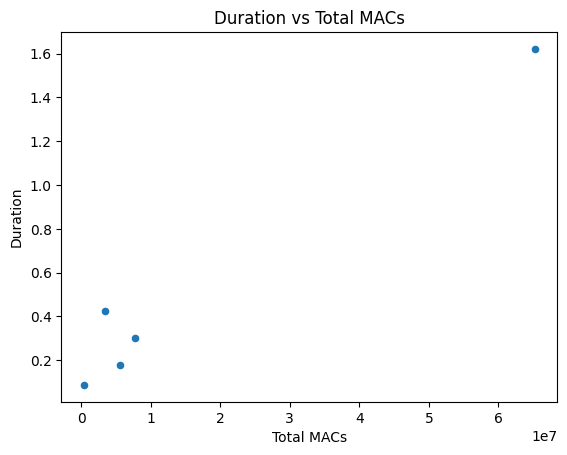

In [ ]:
import matplotlib.pyplot as plt

df.plot(x='total_macs', y='duration', kind='scatter')
plt.xlabel('Total MACs')
plt.ylabel('Duration')
plt.title('Duration vs Total MACs')
plt.show()